In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import pandas as pd
from scipy import spatial
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [13]:
base_model = MobileNet(weights='imagenet', include_top=False)
#add_layer

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)
#Assign transfer learning model to new model

model = Model(inputs=base_model.input, outputs=preds)
model.summary() #Before freezing
for layer in model.layers[:20]:
    layer.trainable = False

for layer in model.layers[20:]:
    layer.trainable = True

model.summary() #After freezing

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


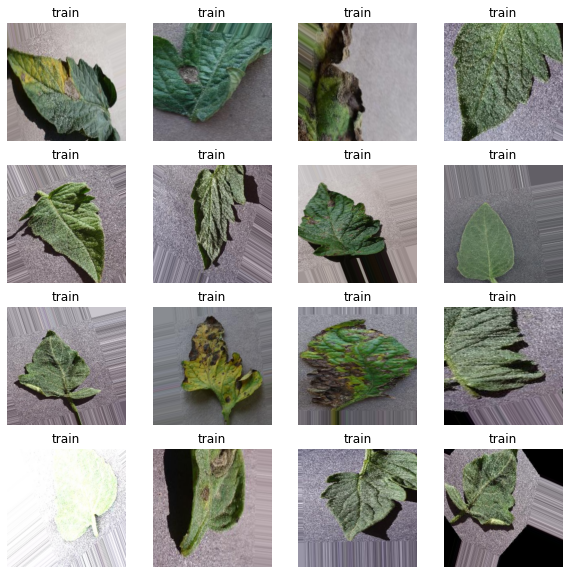

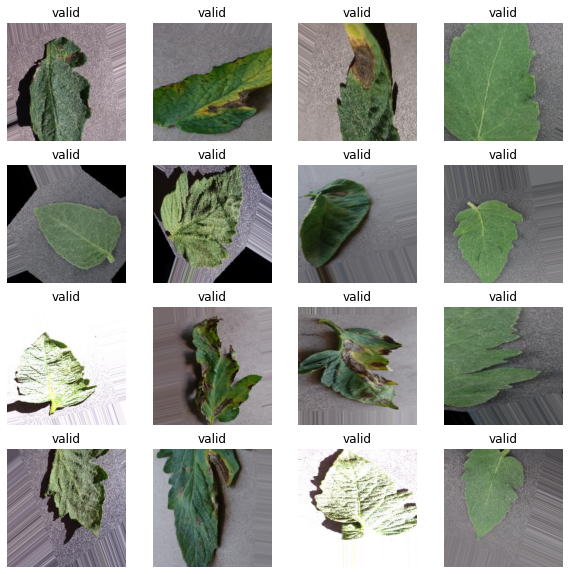

In [14]:
seed_value = 42
# Image generator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, zoom_range=0.5,shear_range=0.15,fill_mode='nearest')
#Generate training and validation data

train_generator = datagen.flow_from_directory( './train/', target_size=(224,224), batch_size=16, class_mode='categorical',color_mode='rgb' , seed=seed_value,shuffle=True)
val_generator = datagen.flow_from_directory( './valid/', target_size=(224,224), batch_size=16, class_mode='categorical',color_mode='rgb' , seed=seed_value,shuffle=True)
def preview_image(datagen):
    x,y = datagen.next()
    plt.figure(figsize=(10,10))
    for j in range(0,16):
        plt.subplot(4,4,j+1)
        plt.imshow(x[j])
        plt.title(str(datagen.directory).split('/')[1])
        plt.axis('off')
    plt.show()

preview_image(train_generator) #Preview training images
preview_image(val_generator) #Preview validation images

In [15]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#training parameters

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
print(step_size_train)
print(step_size_val)

12
12


C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<ipython-input-16-bf9bab8d39ea>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=step_size_train, epochs=EP, validation_data=val_generator, validation_steps=step_size_val)


Epoch 1/20
12/12 [==============================] - 10s 591ms/step - loss: 0.3699 - accuracy: 0.8098 - val_loss: 0.7807 - val_accuracy: 0.5729
Epoch 2/20
12/12 [==============================] - 6s 488ms/step - loss: 0.1698 - accuracy: 0.9293 - val_loss: 0.6966 - val_accuracy: 0.7292
Epoch 3/20
12/12 [==============================] - 5s 460ms/step - loss: 0.0728 - accuracy: 0.9783 - val_loss: 1.3796 - val_accuracy: 0.5625
Epoch 4/20
12/12 [==============================] - 6s 483ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.7930 - val_accuracy: 0.7604
Epoch 5/20
12/12 [==============================] - 8s 721ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.6662 - val_accuracy: 0.7969
Epoch 6/20
12/12 [==============================] - 6s 547ms/step - loss: 0.0285 - accuracy: 0.9946 - val_loss: 0.9153 - val_accuracy: 0.7500
Epoch 7/20
12/12 [==============================] - 6s 470ms/step - loss: 0.0731 - accuracy: 0.9783 - val_loss: 0.2056 - val_accuracy: 0.9062
Epoch

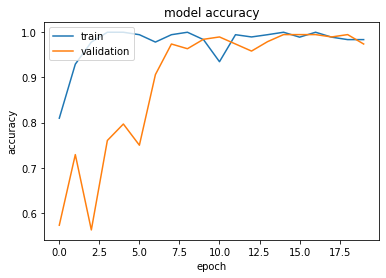

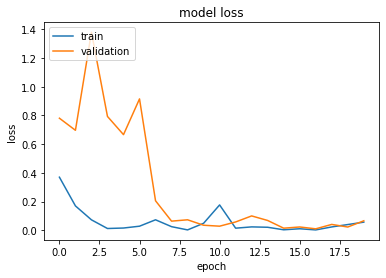

In [16]:
EP = 20
history = model.fit_generator(train_generator, steps_per_epoch=step_size_train, epochs=EP, validation_data=val_generator, validation_steps=step_size_val)
def performanc_plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def performanc_plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

performanc_plot_acc(history)
performanc_plot_loss(history)

In [17]:
test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory( './test/', target_size=(224,224), batch_size=1, class_mode='categorical',color_mode='rgb',shuffle=False)
#class id

y_true = test_generator.classes
#predict

test_generator.reset()
pred_prob = []
for i in range(len(y_true)):
    pred = model.predict(test_generator[i][0])
    pred_prob.append(np.array(pred))
#prediction result

pred_prob = np.array(pred_prob).reshape(len(y_true),2) #reshape to 2 columns
df_pred = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)

Found 16 images belonging to 2 classes.


In [18]:
y_real = y_true
y_pred = model.predict_generator(test_generator, steps=len(test_generator)).argmax(axis=-1)
target_name = test_generator.class_indices
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, target_names=target_name))

<ipython-input-18-b9d80c46af6b>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, steps=len(test_generator)).argmax(axis=-1)


[[6 0]
 [6 4]]
                       precision    recall  f1-score   support

Tomato___Early_blight       0.50      1.00      0.67         6
     Tomato___healthy       1.00      0.40      0.57        10

             accuracy                           0.62        16
            macro avg       0.75      0.70      0.62        16
         weighted avg       0.81      0.62      0.61        16

